In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('prediction_labels.csv')

In [3]:
data

,text,label,VADER,DISTILLBERT,ROBERTA,BertTweet,gpt2,FINBERT
0,"""@mattduss @chrislhayes if ISIS does gain a fo...",0,2,0,0,0,0,0
1,"""Sad news! 150 people shot, drowned in Yobe ri...",0,0,0,0,0,0,0
2,@StephenNolan they all served and died under t...,0,0,0,0,0,0,0
3,Rousey vs. Holm may be the biggest waste of a ...,0,0,0,0,1,0,0
4,@user Amy Schumer is the stereotypical 1st wor...,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
8739,The city experienced a complete blackout after...,0,0,0,0,0,0,0
8740,"After the power outage, the city experienced a...",0,0,0,0,0,0,0
8741,The unexpected blackout plunged the city into ...,0,0,0,0,0,0,0
8742,The company's sudden mobilization of resources...,0,0,0,0,0,0,0


In [16]:
X = data.iloc[:, 2:8].values  
y = data.iloc[:, 1].values  


In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [19]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [22]:
input_size = 6
hidden_size = 64
num_classes = len(set(y))
model = MLP(input_size, hidden_size, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
num_epochs = 40
for epoch in range(num_epochs):
    for inputs, labels in train_loader:

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/40], Loss: 0.3439
Epoch [2/40], Loss: 0.4800
Epoch [3/40], Loss: 0.0867
Epoch [4/40], Loss: 0.5668
Epoch [5/40], Loss: 0.5060
Epoch [6/40], Loss: 0.2550
Epoch [7/40], Loss: 0.1681
Epoch [8/40], Loss: 0.2265
Epoch [9/40], Loss: 0.1319
Epoch [10/40], Loss: 0.2093
Epoch [11/40], Loss: 0.1714
Epoch [12/40], Loss: 0.3008
Epoch [13/40], Loss: 0.3821
Epoch [14/40], Loss: 0.4956
Epoch [15/40], Loss: 0.3146
Epoch [16/40], Loss: 0.6564
Epoch [17/40], Loss: 0.3204
Epoch [18/40], Loss: 0.3497
Epoch [19/40], Loss: 0.1490
Epoch [20/40], Loss: 0.4105
Epoch [21/40], Loss: 0.5850
Epoch [22/40], Loss: 0.7273
Epoch [23/40], Loss: 0.2384
Epoch [24/40], Loss: 0.5321
Epoch [25/40], Loss: 0.5116
Epoch [26/40], Loss: 0.3640
Epoch [27/40], Loss: 0.4160
Epoch [28/40], Loss: 0.0591
Epoch [29/40], Loss: 0.6221
Epoch [30/40], Loss: 0.3790
Epoch [31/40], Loss: 0.4114
Epoch [32/40], Loss: 0.2633
Epoch [33/40], Loss: 0.3860
Epoch [34/40], Loss: 0.2121
Epoch [35/40], Loss: 0.2421
Epoch [36/40], Loss: 0.3778
E

In [28]:
model.eval()
predicted_v = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_v = predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

Accuracy of the model on the test set: 87.19%


In [29]:
predicted_v

tensor([0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 0, 1, 0, 2, 2, 1])

In [30]:
torch.save(model.state_dict(), 'mlp_ensemble')
print("Model saved to 'mlp_model.pth'")

Model saved to 'mlp_model.pth'


Accuracy: 0.87
Precision: 0.86
Recall: 0.86
F1 Score: 0.86


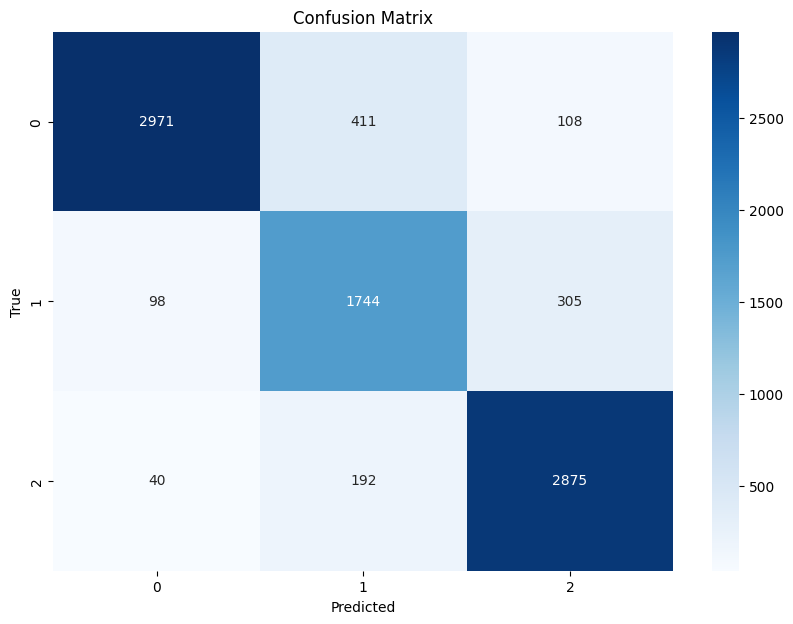

In [33]:
X_tensor = torch.tensor(X, dtype=torch.float32)

# Assuming you have a trained model
# Replace this with your actual model loading code
# Example: model = YourModelClass()
# model.load_state_dict(torch.load('path_to_your_model.pth'))
model.eval()  # Set the model to evaluation mode

# Make predictions
with torch.no_grad():
    outputs = model(X_tensor)

# Convert the model outputs to predicted labels
predicted_labels = torch.argmax(outputs, dim=1).numpy()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = accuracy_score(y, predicted_labels)
precision = precision_score(y, predicted_labels, average='macro')
recall = recall_score(y, predicted_labels, average='macro')
f1 = f1_score(y, predicted_labels, average='macro')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y, predicted_labels)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()